# Does spike shape predict sparse cell misses?

author: steeve.laquitaine@epfl.ch


Test Hyp: Missed sparse cell spike shapes are distinct from the detected cells' ones, which fit one of KS3's six universal templates.

Approach: compare their distance (proxy for shape similarity) to the universal templates in a projection space.

Scope: single-channel spikes of pyramidal cells on channel 30 (two detected pyramidal cells only near channel 30)


## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [556]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# SET DIMENSIONALITY REDUCTION tools
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)


# SETUP PROJECT PACKAGE
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.pipes.postpro import univ_temp, reduction


# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CHANNEL AND NEAREST CELLS
NEAREST_CHANNEL = 30
MISSED_CELL_IDS = [165135, 288502, 273515, 288502, 342702, 37423, 39862, 424433]
DETECTED_CELL_IDS = [19690, 367098]  


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]


# SET PLOT PARAMETERS
N_TOTAL_COLORS = 30
N_DETECTED_COLORS = 15
colors = np.array(sns.color_palette('tab10', n_colors=N_TOTAL_COLORS))
detected_colors = colors[:N_DETECTED_COLORS,]
missed_colors = colors[N_DETECTED_COLORS:,]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'reduction' from 'src.pipes.postpro' (unknown location)

1. choose a channel
2. find nearby ground truth cells (within 40 microns of the channel)
3. reduce dimensionality of spikes and universal templates
4. plot univ. templates, missed sparse cells, detected sparse cells on the reduced space

Spike dataset engineering was done with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

## Load spike data

In [545]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

## Check templates, missed and detected cell spikes

spike count: 66
2023-05-05 16:36:54,922 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-05 16:36:54,936 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
spike count: 5
2023-05-05 16:36:55,070 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-05 16:36:55,085 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


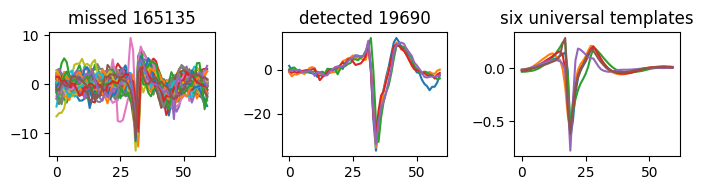

In [546]:
# plot a missed sparse cell
NEAREST_CHANNEL = 30
MISSED_CELL = 165135
DETECTED_CELL = 19690

# setup plots
fig, axes = plt.subplots(1,3, figsize=(7,2))

# plot a missed sparse cell
missed_cell_instances = all_instances.iloc[np.where((cells.values==MISSED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[0].plot(missed_cell_instances.T);
axes[0].set_title(f"missed {MISSED_CELL}");
print("spike count:", missed_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[MISSED_CELL] == missed_cell_instances.shape[0], "spike count does not make sense"

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[1].plot(detected_cell_instances.T);
axes[1].set_title(f"detected {DETECTED_CELL}");

print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
univ_templates = univ_temp.load(data_conf)
univ_templates = univ_templates.T[:,:-1]
univ_templates = univ_templates
axes[2].plot(univ_templates.T);
axes[2].set_title("six universal templates");

plt.tight_layout()

## Fit templates to spikes via projection

In [547]:
# get their spikes (samples x timepoint features)
missed_sparse_loc = np.where((cells.values==MISSED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
missed_sparse_instances = all_instances.iloc[missed_sparse_loc,:]

# create associated cell labels
missed_sparse_cell_labels = cells.values[missed_sparse_loc]
missed_sparse_instances

# Engineer detected spike data
# ----------------------------
# get their spikes (samples x timepoint features)
detected_sparse_loc = np.where((cells.values==DETECTED_CELL_IDS) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()
detected_sparse_instances = all_instances.iloc[detected_sparse_loc,:]

# create associated cell labels
detected_sparse_cell_labels = cells.values[detected_sparse_loc]

# -----------------------------
# concatenate into data for dim. reduction
near_contact_instances = np.vstack([missed_sparse_instances, detected_sparse_instances])

# convert cell label to integer labels
near_contact_cell_labels = np.vstack([missed_sparse_cell_labels, detected_sparse_cell_labels])
labels_as_intg = np.unique(near_contact_cell_labels, axis=0, return_inverse=True)[1]

# add detection status label (detected are "1", missed "0")
detection_status = np.sum(near_contact_cell_labels == DETECTED_CELL_IDS, axis=1)

# label universal templates by incrementing the cell labels already in the instances
univ_templates_labels = np.arange(1, univ_templates.shape[0]+1,1) + max(labels_as_intg)

# add
labels = np.hstack([labels_as_intg, univ_templates_labels])
# instances = np.vstack([near_contact_instances, univ_templates])
detected = np.hstack([detection_status, np.ones(univ_templates.shape[0])])

## Plot raw template 1 and spikes

We plotted the missed (empty circle) and detected (full circles) cell spikes near the same contact 30, on a reduced feature space.

2023-05-05 16:36:56,872 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


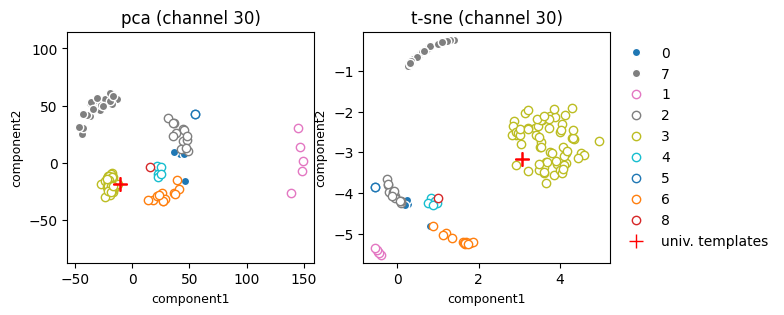

In [548]:
# Plot the data and reconstruction
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding = reduction.pca_spikes(axis=axes[0], spike_instances=near_contact_instances, templates=univ_templates,labels=labels, detection_status=detected, detected_colors=detected_colors, missed_colors=missed_colors)
tsne_embedding = reduction.tsne_spikes(axis=axes[1], spike_instances=near_contact_instances, templates=univ_templates, labels=labels, detection_status=detected, detected_colors=detected_colors, missed_colors=missed_colors)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

## Plot fitted (scaled-only) template 1 and spikes

Scaling a template translates its coordinates along a line (red crosses) in pca space.

In [549]:
# fit template to spikes
template = univ_templates[0,:]

amplitude_x = np.dot(near_contact_instances, template)
template_fits = np.outer(amplitude_x, template)

# label universal templates by incrementing the cell labels already in the instances
template_fits_labels = np.arange(1, template_fits.shape[0]+1,1) + max(labels_as_intg)

# add
labels_for_scaled = np.hstack([labels_as_intg, template_fits_labels])
detected_for_scaled = np.hstack([detection_status, np.ones(template_fits.shape[0])])

2023-05-05 16:37:04,237 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-05-05 16:37:16,906 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


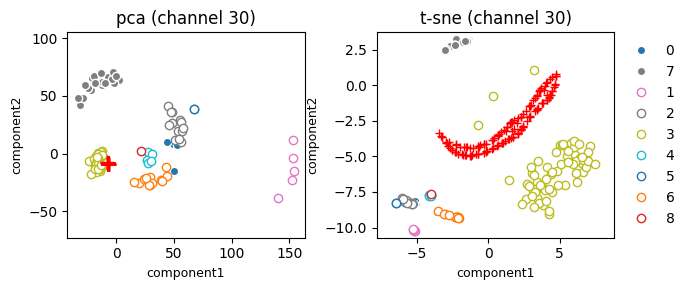

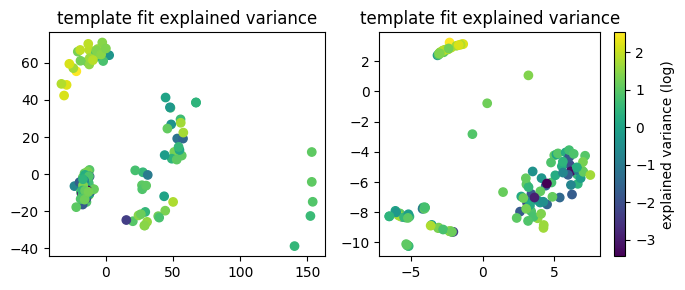

In [550]:
# Plot the data and reconstruction
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding, pca_model = reduction.pca_spikes_and_template_fits(axis=axes[0], spike_instances=near_contact_instances, template_fits=template_fits, labels=labels_for_scaled, detection_status=detected_for_scaled, detected_colors=detected_colors, missed_colors=missed_colors)
tsne_embedding, tsne_model = reduction.tsne_spikes_and_template_fits(axis=axes[1], spike_instances=near_contact_instances, template_fits=template_fits, labels=labels_for_scaled, detection_status=detected_for_scaled, detected_colors=detected_colors, missed_colors=missed_colors)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
plt.tight_layout()

# calculate explained variance of fits for each spike
explained_var = amplitude_x**2

# scatter plot with colored dots
fig, axes = plt.subplots(1,2, figsize=(7,3))
mappable = axes[0].scatter(pca_embedding[:len(explained_var),0], pca_embedding[:len(explained_var),1], c=np.log10(explained_var), cmap="viridis")
mappable = axes[1].scatter(tsne_embedding[:len(explained_var),0], tsne_embedding[:len(explained_var),1], c=np.log10(explained_var), cmap="viridis")

# legend
axes[0].set_title(f"template fit explained variance")
axes[1].set_title(f"template fit explained variance")
plt.colorbar(mappable, label="explained variance (log)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
plt.tight_layout()

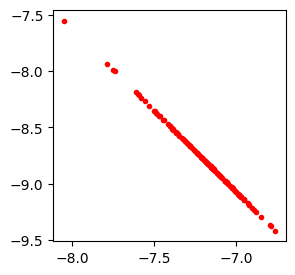

In [551]:
# zoom on the template fits embeddings
plt.figure(figsize=(3,3))
n_spikes = len(near_contact_instances)
plt.plot(pca_embedding[n_spikes:,0], pca_embedding[n_spikes:,1], "r.");

In [552]:
print("pca's explained variance by component:", pca_model.explained_variance_ratio_)
print("total explained variance:", sum(pca_model.explained_variance_ratio_))

pca's explained variance by component: [0.53246295 0.3348939 ]
total explained variance: 0.8673568665981293


## Plot re-scaled template 2 and spikes

2023-05-05 16:37:20,997 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


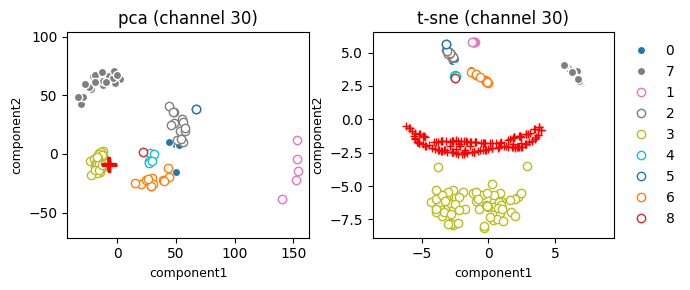

In [553]:
# fit the second template and plot with spikes in reduced space
template2 = univ_templates[1,:]

# fit template to spikes
amplitude_x2 = np.dot(near_contact_instances, template2)
template_fits2 = np.outer(amplitude_x2, template2)

# label universal templates by incrementing the cell labels already in the instances
template_fits_labels2 = np.arange(1, template_fits2.shape[0]+1,1) + max(labels_as_intg)

# add
labels_for_scaled2 = np.hstack([labels_as_intg, template_fits_labels2])
detected_for_scaled2 = np.hstack([detection_status, np.ones(template_fits2.shape[0])])

# Plot the data and reconstruction
fig, axes = plt.subplots(1,2, figsize=(7,3))

# apply dim. reductions
pca_embedding, pca_model = reduction.pca_spikes_and_template_fits(axis=axes[0], spike_instances=near_contact_instances, template_fits=template_fits2, labels=labels_for_scaled2, detection_status=detected_for_scaled2, detected_colors=detected_colors, missed_colors=missed_colors)
tsne_embedding, tsne_model = reduction.tsne_spikes_and_template_fits(axis=axes[1], spike_instances=near_contact_instances, template_fits=template_fits2, labels=labels_for_scaled2, detection_status=detected_for_scaled2, detected_colors=detected_colors, missed_colors=missed_colors)

# legend
axes[0].set_title(f"pca (channel {NEAREST_CHANNEL})")
axes[1].set_title(f"t-sne (channel {NEAREST_CHANNEL})")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);
plt.tight_layout()

## Check template 1 fits

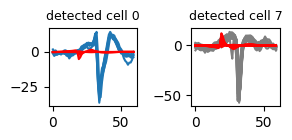

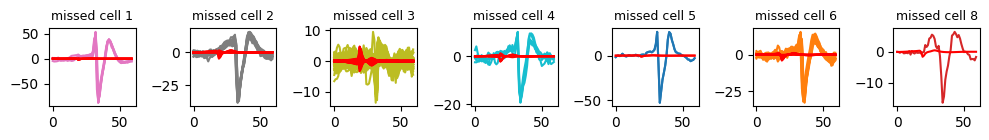

In [600]:
# plot detected

detected_labels = np.unique(labels[np.where(detection_status==1)[0]])
detected_labels

fig, axes = plt.subplots(1,len(detected_labels), figsize=(3,1.5))

# plot spikes
for ix, label_i in enumerate(detected_labels):
    axes[ix].plot(near_contact_instances[labels_as_intg==label_i].T, color=detected_colors[label_i,:]);

    # plot best fit templates
    axes[ix].plot(template_fits[labels_as_intg==label_i].T, "r");
    axes[ix].set_title(f"detected cell {label_i}", fontsize=9)
plt.tight_layout()

# plot missed

missed_labels = np.unique(labels[np.where(detection_status==0)[0]])
missed_labels

fig, axes = plt.subplots(1,len(missed_labels), figsize=(10,1.5))

# plot spikes
for ix, label_i in enumerate(missed_labels):
    axes[ix].plot(near_contact_instances[labels_as_intg==label_i].T, color=missed_colors[label_i,:]);

    # plot best fit templates
    axes[ix].plot(template_fits[labels_as_intg==label_i].T, "r");
    axes[ix].set_title(f"missed cell {label_i}", fontsize=9)
plt.tight_layout()

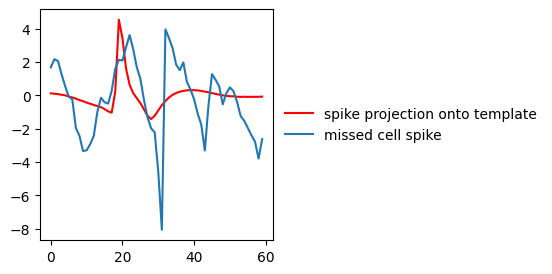

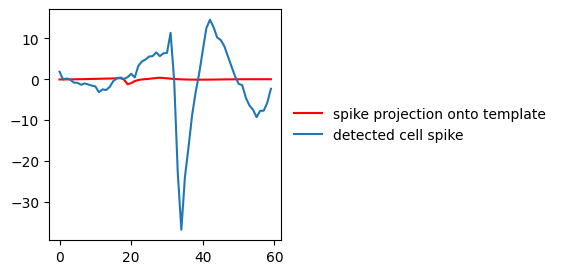

In [555]:
# show a real missed spike and its best fit (its projection on a) template
D = missed_cell_instances.iloc[0].values
W = univ_templates[0,:]
amplitude_x = np.dot(D, W)

# plot
plt.subplots(figsize=(3, 3))
plt.plot(amplitude_x * W, "r", label="spike projection onto template");
plt.plot(D, label="missed cell spike");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

# show a real detected spike and its best fit (its projection on a) template
D = detected_cell_instances.iloc[0].values
amplitude_x = np.dot(D, W)

# plot
plt.subplots(figsize=(3, 3))
plt.plot(amplitude_x * W, "r", label="spike projection onto template");
plt.plot(D, label="detected cell spike");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);